In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import BinaryDataGenerator
from models import WeibullModel
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all.keys()

dict_keys(['val', 'cv'])

In [5]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

Set common parameters for learning

In [6]:
folds = list(df_all['cv'].keys())

Define parameters grid

In [14]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 30

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid   
}

In [15]:
# 12 combinations
batch_size = [1024, 2048]
alpha_reg = [1e-4, 1e-5, 1e-6]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
}
grid = ParameterGrid(param_grid)

Define testing function

In [16]:
def test_hp(train_data, test_data, model_params):
        
    model = WeibullModel(model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'])
    
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }                   
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
              
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run(model.loss, feed_dict={
                        model.x_a: x_batch_left_val, 
                        model.x_b: x_batch_right_val, 
                        model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                        model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                        model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                        model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                        model.target: target_val.reshape((val_size, 1)),
                        model.sample_weight: sample_weight_val
                    }) 
                val_loss.append(l)
                
    return pred, train_loss, val_loss, all_lr


Grid search

In [17]:
all_res_quality = []
test_data = df_all['val']
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    for params in tqdm(grid):
        tf.reset_default_graph()
        params.update(static_params)
        pred, train_loss, val_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
        q['batch_size'] = params['batch_size']
        q['alpha_reg'] = params['alpha_reg']
        q['fold'] = fold
        q['train_loss'] = [train_loss]
        q['val_loss'] = [val_loss]
        q['learning_rate'] = [all_lr]
        all_res_quality.append(q)
       
        with open('../output/hp_search_w_v2.pkl', 'wb') as f:
            pickle.dump(all_res_quality, f)

Select best hyperparameters on validation data

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

In [2]:
with open('../output/hp_search_w_v2.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data = pd.concat(data)

In [7]:
data

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss,learning_rate
0,0.657802,0.657882,0.164816,0.487166,1024,0.000100,0,"[4.802493, 3.69207, 3.1010413, 2.938915, 2.774...","[4.6237836, 3.5263145, 3.06665, 2.8486507, 2.7...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.652703,0.654383,0.166230,0.491296,2048,0.000100,0,"[6.468911, 4.427576, 3.7138445, 3.3988082, 3.1...","[6.16966, 4.2556825, 3.6680198, 3.362769, 3.09...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.657942,0.658862,0.163650,0.484565,1024,0.000010,0,"[4.9887877, 3.7855155, 3.195269, 3.0020714, 2....","[4.934867, 3.6011877, 3.1629174, 2.9045424, 2....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.652243,0.654663,0.165193,0.489071,2048,0.000010,0,"[6.402765, 4.6769495, 3.8446195, 3.4478428, 3....","[6.404928, 4.5418925, 3.758809, 3.422308, 3.19...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.657862,0.659082,0.163532,0.484306,1024,0.000001,0,"[4.9981613, 3.8035002, 3.2104115, 3.0116208, 2...","[4.9670706, 3.6156416, 3.1793725, 2.9121883, 2...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.651924,0.654703,0.165091,0.488856,2048,0.000001,0,"[6.407334, 4.681964, 3.8682976, 3.4574037, 3.2...","[6.4398055, 4.577417, 3.7808661, 3.4333577, 3....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.652883,0.652223,0.165092,0.487397,1024,0.000100,1,"[4.937795, 3.4866471, 3.0729706, 2.8559692, 2....","[4.4237413, 3.3243244, 3.0167356, 2.826058, 2....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.649384,0.647605,0.166746,0.491846,2048,0.000100,1,"[6.528525, 4.22577, 3.5582035, 3.3009157, 3.16...","[6.021517, 4.1120996, 3.458471, 3.1924136, 3.0...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.652263,0.653003,0.163945,0.484819,1024,0.000010,1,"[5.378942, 3.6552672, 3.1164176, 2.870306, 2.8...","[4.9283123, 3.4245584, 3.03786, 2.83734, 2.707...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.648944,0.647924,0.165696,0.489555,2048,0.000010,1,"[6.519559, 4.5734386, 3.7517507, 3.384844, 3.2...","[6.371698, 4.514035, 3.6481724, 3.233784, 3.05...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."


In [8]:
data['mean_3_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-5:])))
data['mean_3_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-5:])))

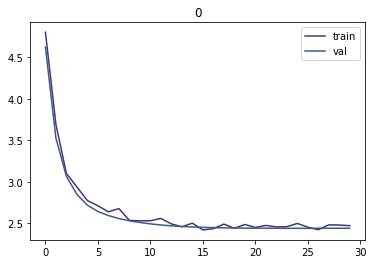

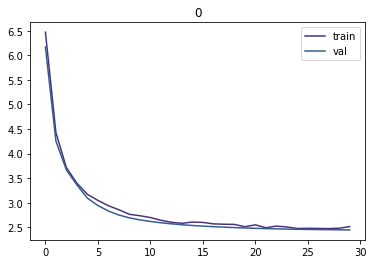

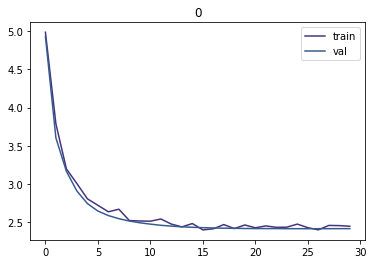

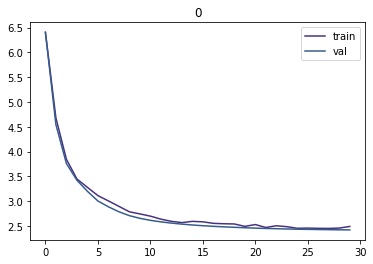

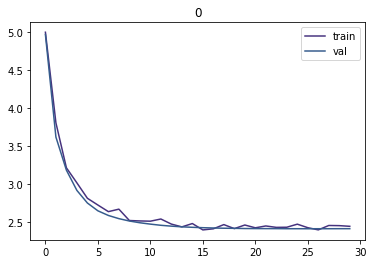

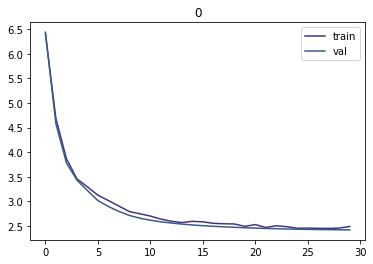

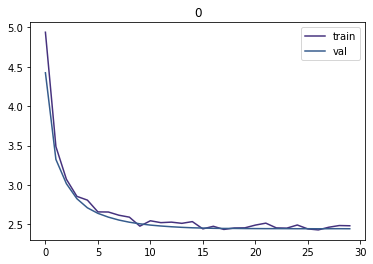

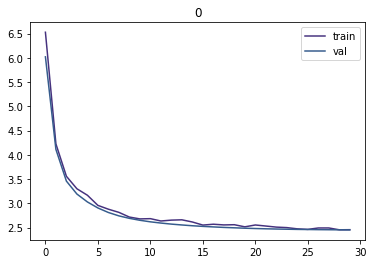

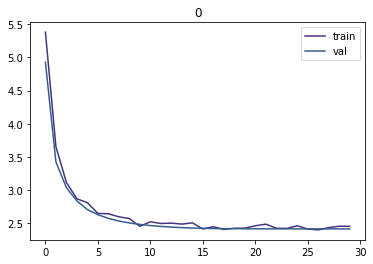

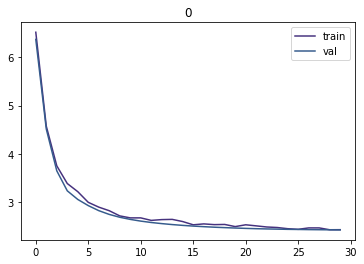

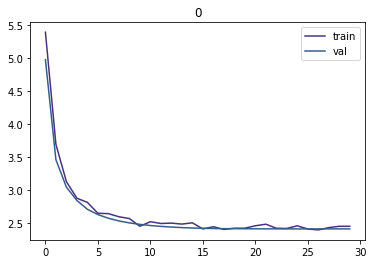

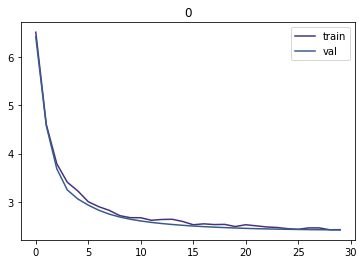

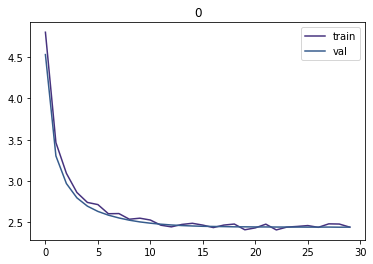

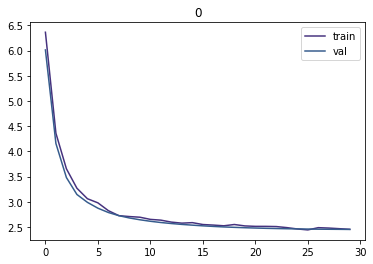

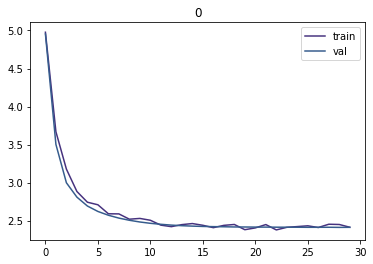

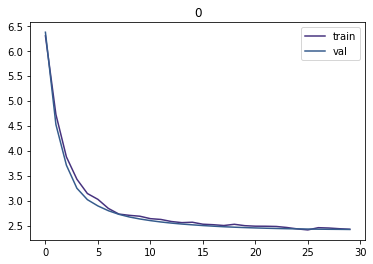

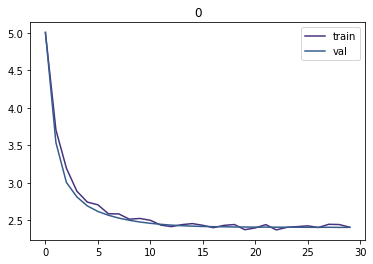

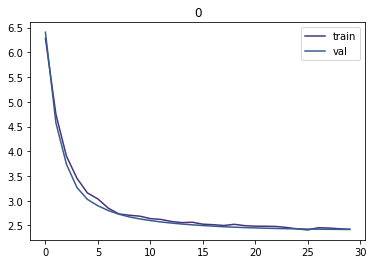

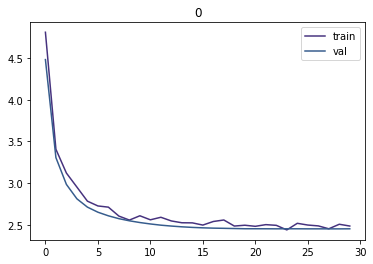

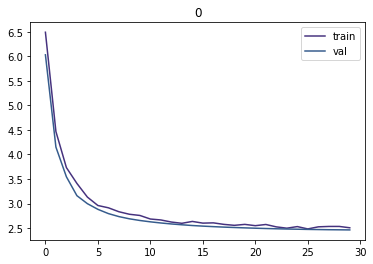

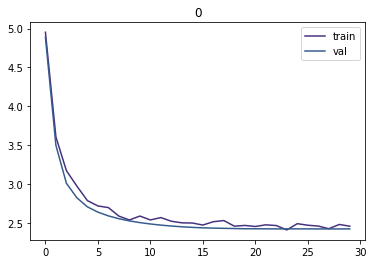

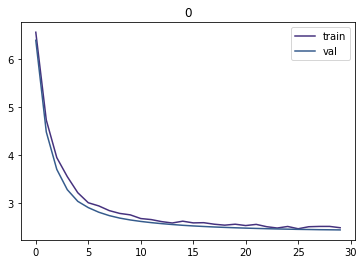

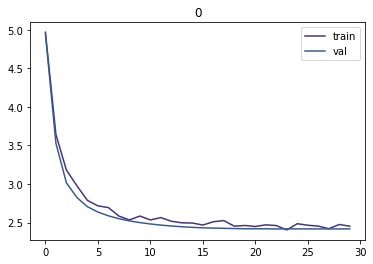

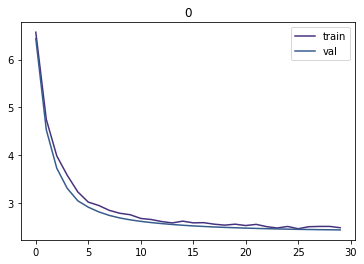

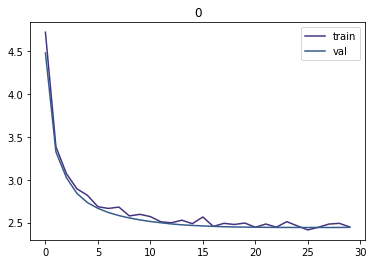

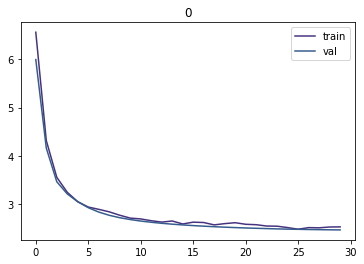

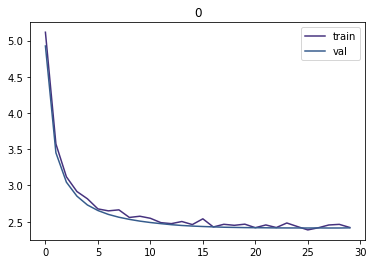

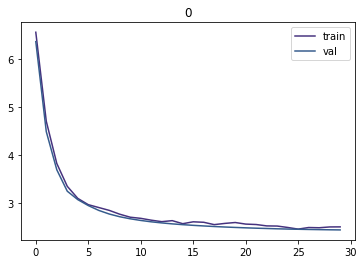

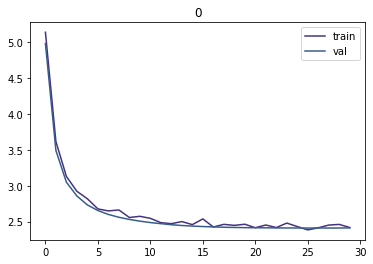

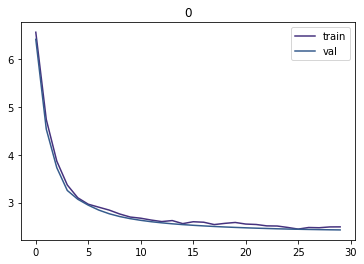

In [9]:
for idx, row in data.iterrows():
    plt.plot(row['train_loss'], label='train')
    plt.plot(row['val_loss'], label='val')
    plt.title(idx)
    plt.legend()
    plt.show();

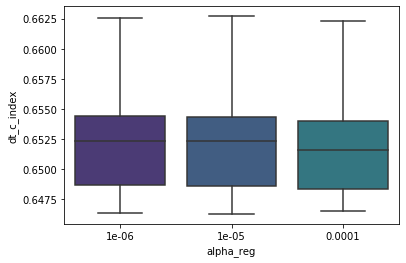

In [10]:
sns.boxplot(data=data, x='alpha_reg', y='dt_c_index');

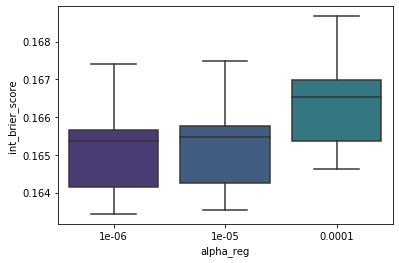

In [11]:
sns.boxplot(data=data, x='alpha_reg', y='int_brier_score');

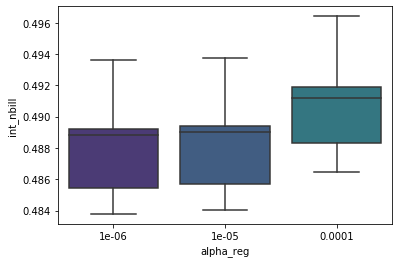

In [12]:
sns.boxplot(data=data, x='alpha_reg', y='int_nbill');

the less alpha_reg the better

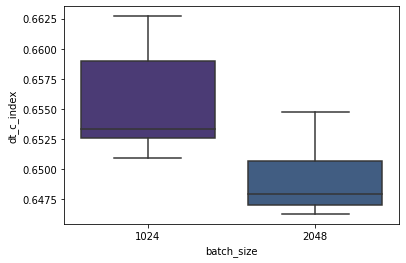

In [13]:
sns.boxplot(data=data, x='batch_size', y='dt_c_index');

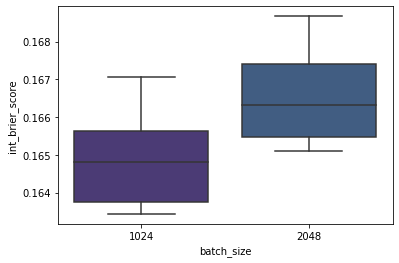

In [14]:
sns.boxplot(data=data, x='batch_size', y='int_brier_score');

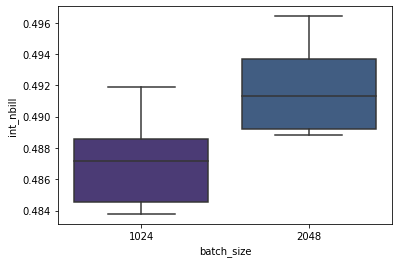

In [15]:
sns.boxplot(data=data, x='batch_size', y='int_nbill');

In [16]:
melted_data = pd.melt(data, id_vars=['batch_size','alpha_reg','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

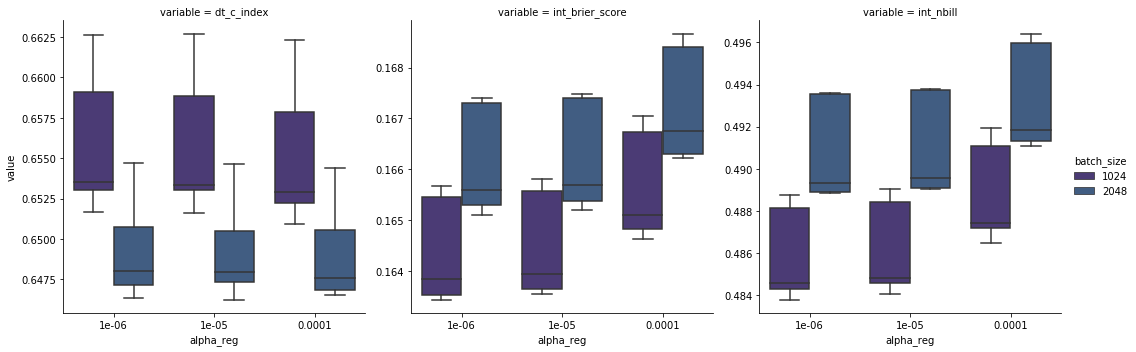

In [17]:
sns.catplot(data=melted_data, kind='box', x='alpha_reg', y='value', hue='batch_size', col='variable', sharey=False)

In [18]:
best_params = data.groupby(['alpha_reg','batch_size'])[['dt_c_index', 'int_brier_score', 'int_nbill', 
                                                                                'mean_3_train_loss', 'mean_5_train_loss',
                                                                                'mean_3_val_loss', 'mean_5_val_loss']].mean()

In [19]:
best_params['dt_c_index_rank'] = best_params['dt_c_index'].rank(ascending=False)
best_params['int_brier_score_rank'] = best_params['int_brier_score'].rank()
best_params['int_nbill_rank'] = best_params['int_nbill'].rank()

In [20]:
best_params.sort_values('dt_c_index', ascending=False)

,,dt_c_index,int_brier_score,int_nbill,mean_3_train_loss,mean_5_train_loss,mean_3_val_loss,mean_5_val_loss,dt_c_index_rank,int_brier_score_rank,int_nbill_rank
alpha_reg,batch_size,,,,,,,,,,
0.000001,1024,0.655975,0.164383,0.485908,2.443941,2.433345,2.411632,2.411579,1.0,1.0,1.0
0.000010,1024,0.655899,0.164502,0.486171,2.446789,2.436199,2.414590,2.414545,2.0,2.0,2.0
0.000100,1024,0.655259,0.165666,0.488808,2.475320,2.464796,2.444180,2.444100,3.0,3.0,3.0
0.000001,2048,0.649388,0.166137,0.490849,2.463502,2.459885,2.425879,2.428645,4.0,4.0,4.0
0.000010,2048,0.649336,0.166229,0.491040,2.466035,2.462369,2.428539,2.431263,5.0,5.0,5.0
0.000100,2048,0.649180,0.167272,0.493321,2.492865,2.488942,2.456631,2.459047,6.0,6.0,6.0


In [21]:
best = data[(data['batch_size'] == 1024) & (data['alpha_reg'] == 1e-6) ]
best

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss,learning_rate,mean_3_train_loss,mean_5_train_loss,mean_3_val_loss,mean_5_val_loss
0,0.657862,0.659082,0.163532,0.484306,1024,0.000001,0,"[4.9981613, 3.8035002, 3.2104115, 3.0116208, 2...","[4.9670706, 3.6156416, 3.1793725, 2.9121883, 2...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",2.445620,2.429948,2.407491,2.407289
0,0.652113,0.653023,0.163831,0.484569,1024,0.000001,1,"[5.3926334, 3.6948383, 3.129274, 2.8779016, 2....","[4.9770703, 3.4617941, 3.0458908, 2.8440566, 2...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",2.446227,2.429660,2.413527,2.413419
0,0.653843,0.651644,0.163434,0.483780,1024,0.000001,2,"[4.9989243, 3.7063437, 3.195998, 2.8891063, 2....","[5.0058694, 3.5373173, 3.006436, 2.813359, 2.6...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",2.434927,2.427918,2.408577,2.408707
0,0.652763,0.653523,0.165673,0.488756,1024,0.000001,3,"[4.969083, 3.6424742, 3.1812348, 2.9770768, 2....","[4.94626, 3.5294876, 3.0150228, 2.824938, 2.70...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",2.449332,2.453445,2.417461,2.417505
0,0.657182,0.662601,0.165446,0.488130,1024,0.000001,4,"[5.1430326, 3.616625, 3.130361, 2.9230213, 2.8...","[4.984396, 3.4920194, 3.050023, 2.8574035, 2.7...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",2.443600,2.425752,2.411102,2.410977


Evaluate quality on CV

In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import BinaryDataGenerator
from models import WeibullModel
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

In [5]:
folds = list(df_all['cv'].keys())

Define optimal parameters

In [9]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 30

params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'alpha_reg': 1e-6,
    'batch_size': 1024,
    'model_path':'../model/opt_weibull_model_'
}

In [10]:
def test_hp(train_data, test_data, model_params):
        
    model = WeibullModel(model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'])
    
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    
    saver = tf.train.Saver()
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }                   
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                # save model
                saver.save(sess, model_params['model_path'] + str(model_params['fold']))              
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run(model.loss, feed_dict={
                        model.x_a: x_batch_left_val, 
                        model.x_b: x_batch_right_val, 
                        model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                        model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                        model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                        model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                        model.target: target_val.reshape((val_size, 1)),
                        model.sample_weight: sample_weight_val
                    }) 
                val_loss.append(l)
                
    return pred, train_loss, val_loss, all_lr


Evaluation of test

In [11]:
all_res_quality = []
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    test_data = df_all['cv'][fold]['test']
    tf.reset_default_graph()
    params.update({'fold': fold})
    pred, train_loss, val_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
    q['batch_size'] = params['batch_size']
    q['alpha_reg'] = params['alpha_reg']
    q['fold'] = fold
    q['train_loss'] = [train_loss]
    q['val_loss'] = [val_loss]
    q['learning_rate'] = [all_lr]
    all_res_quality.append(q)

    with open('../output/optimal_w_2.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

In [3]:
with open('../output/optimal_w_ce_3.pkl', 'rb') as f:
    data = pickle.load(f)
data = pd.concat(data)

In [4]:
data

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,cross_entropy_weight,fold,train_loss,val_loss,learning_rate
0,0.649475,0.644742,0.184539,0.542446,1024,0.000001,5,0,"[9.764683, 8.523368, 8.00642, 7.7305145, 7.531...","[10.510186, 8.723924, 7.9377594, 7.7341356, 7....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."


In [14]:
with open('../output/optimal_w_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [15]:
data = pd.concat(data)

In [17]:
data

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss,learning_rate
0,0.645200,0.638573,0.177541,0.528777,1024,0.000001,0,"[4.8938146, 3.7653172, 3.311651, 3.0255404, 2....","[5.7073092, 4.014643, 3.3613827, 3.0225778, 2....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.630378,0.640637,0.172420,0.508956,1024,0.000001,1,"[5.0643735, 3.5566185, 3.140715, 2.9239223, 2....","[5.0190234, 3.6953995, 3.1438627, 2.8915458, 2...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.628016,0.593271,0.178833,0.526040,1024,0.000001,2,"[5.0818424, 3.6147506, 3.0041957, 2.897737, 2....","[4.820728, 3.475778, 3.0899835, 2.9383147, 2.8...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.648527,0.661591,0.171535,0.511884,1024,0.000001,3,"[5.1402917, 3.6868937, 3.0476782, 2.908164, 2....","[4.8246293, 3.501074, 3.0427136, 2.812774, 2.6...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.661082,0.623233,0.175892,0.517342,1024,0.000001,4,"[5.1088376, 3.6939883, 3.121592, 2.8642254, 2....","[5.4642267, 3.8648028, 3.3371217, 3.0489619, 2...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."


In [18]:
data['mean_3_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-5:])))
data['mean_3_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-5:])))

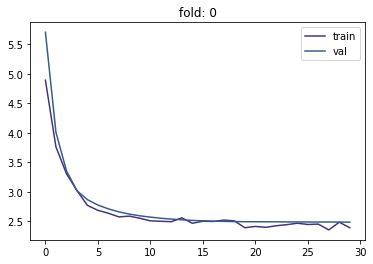

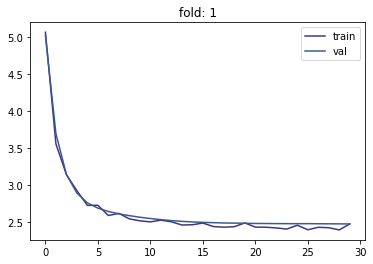

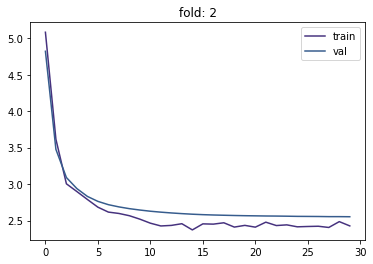

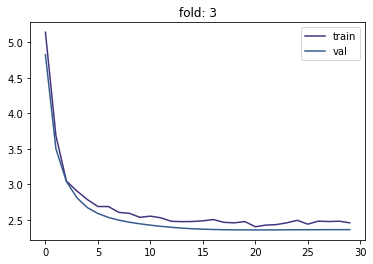

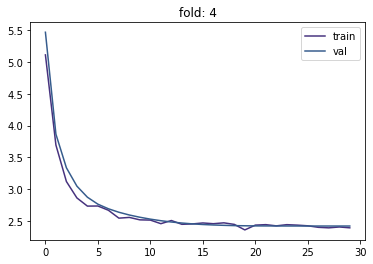

In [21]:
for idx, row in data.iterrows():
    plt.plot(row['train_loss'], label='train')
    plt.plot(row['val_loss'], label='val')
    plt.title("fold: {}".format(row['fold']))
    plt.legend()
    plt.show();

In [23]:
melted_data = pd.melt(data, id_vars=['batch_size','alpha_reg','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

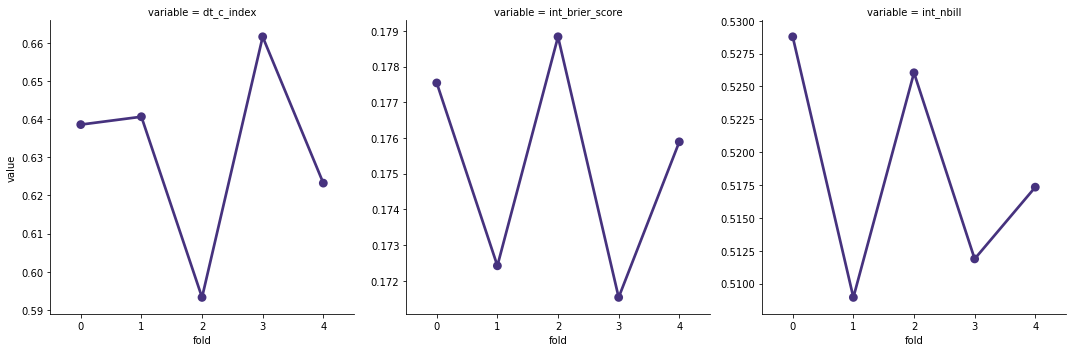

In [35]:
sns.catplot(data=melted_data, x='fold', kind='point', y='value', col='variable', sharey=False);

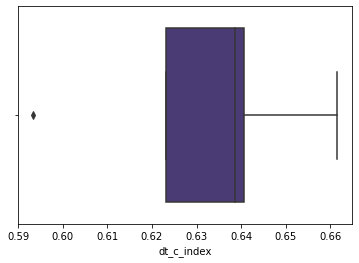

In [37]:
sns.boxplot(data['dt_c_index'])

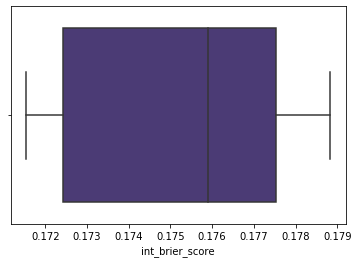

In [38]:
sns.boxplot(data['int_brier_score'])

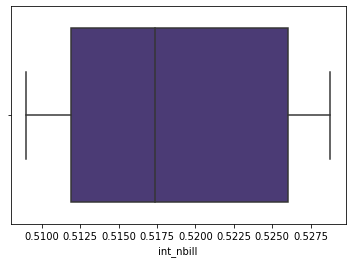

In [39]:
sns.boxplot(data['int_nbill'])

In [40]:
mean_quality = data.groupby(['alpha_reg','batch_size'])[['dt_c_index', 'int_brier_score', 'int_nbill', 
                                                                                'mean_3_train_loss', 'mean_5_train_loss',
                                                                                'mean_3_val_loss', 'mean_5_val_loss']].mean()

In [41]:
mean_quality.sort_values('dt_c_index', ascending=False)

,,dt_c_index,int_brier_score,int_nbill,mean_3_train_loss,mean_5_train_loss,mean_3_val_loss,mean_5_val_loss
alpha_reg,batch_size,,,,,,,
0.000001,1024,0.631461,0.175244,0.5186,2.431392,2.43199,2.461519,2.461905
